In [1]:
#Install yolov8 package
!pip install ultralytics -qq

In [2]:
#Install Detection package and Yolov8 
import cv2
from ultralytics import YOLO

#Import library for plotting plots using plt and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

#Import library for displaying image and videos
import IPython
from IPython.display import Video, display
%matplotlib inline
import urllib.request 
import shutil

#Import python basic packages - Numpy, Pandas, json.os, and progress bar sequencer tqdm
import pandas as pd
import numpy as np
import os
import subprocess
from tqdm.notebook import tqdm


# This code utilizes Yolov8 model for number of people detecting and counter in specified ROI region
----------------------
 **By running this code you will know how to(s):**
1. Detecting people that moving across in a defined ROI (Region Of Interest)
2. Tracking Individuals with ID(s) while moving inside the ROI
3. Adjusting the parameters within the detection
4. Adjusting the ROI parameters
5. Understanding briefly how YoloV8 works

---------------------

In [3]:
# Define the Video path for experiment
path_zip = 'https://github.com/freedomwebtech/roiinyolo/raw/main/vid1.zip' # credits to the github repo for the video
urllib.request.urlretrieve(path_zip, "vid1.zip")
shutil.unpack_archive('/kaggle/working/vid1.zip', '/kaggle/working/')

path = '/kaggle/working/vid1.mp4'

**Load the weight model of Yolov8**

In [4]:
#loading a YOLO model 
model = YOLO('yolov8x.pt')

#geting names from classes
dict_classes = model.model.names

  0%|          | 0.00/131M [00:00<?, ?B/s]

In [5]:
# Preprocessing function to resize the input image
def resize_frame(frame, scale_percent):
    """Function to resize an image in a percent scale"""
    width = int(frame.shape[1] * scale_percent / 100)
    height = int(frame.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
    return resized



def filter_tracks(centers, patience):
    """Function to filter track history"""
    filter_dict = {}
    for k, i in centers.items():
        d_frames = i.items()
        filter_dict[k] = dict(list(d_frames)[-patience:])

    return filter_dict


def update_tracking(centers_old,obj_center, thr_centers, lastKey, frame, frame_max):
    """Function to update track of objects"""
    is_new = 0
    lastpos = [(k, list(center.keys())[-1], list(center.values())[-1]) for k, center in centers_old.items()]
    lastpos = [(i[0], i[2]) for i in lastpos if abs(i[1] - frame) <= frame_max]
    # Calculating distance from existing centers points
    previous_pos = [(k,obj_center) for k,centers in lastpos if (np.linalg.norm(np.array(centers) - np.array(obj_center)) < thr_centers)]
    # if distance less than a threshold, it will update its positions
    if previous_pos:
        id_obj = previous_pos[0][0]
        centers_old[id_obj][frame] = obj_center
    
    # Else a new ID will be set to the given object
    else:
        if lastKey:
            last = lastKey.split('D')[1]
            id_obj = 'ID' + str(int(last)+1)
        else:
            id_obj = 'ID0'
            
        is_new = 1
        centers_old[id_obj] = {frame:obj_center}
        lastKey = list(centers_old.keys())[-1]

    
    return centers_old, id_obj, is_new, lastKey


# Tracking and detect the target (people) in the ROI
**The main functions are as follow:**
* Define the parameters of ROI : threshold, scaling, dummy to store detected target
* Test the model by giving the model input dataset in video format
* Define the image frame hxw
* Specify the targeted object : in this term People
* Define the bounding box for target in recognition (Bounding Box)

In [6]:

### Configurations
#Verbose during prediction
verbose = False
# Scaling percentage of original frame
scale_percent = 100
# model confidence level
conf_level = 0.8
# Threshold of centers ( old\new)
thr_centers = 20
#Number of max frames to consider a object lost 
frame_max = 5
# Number of max tracked centers stored 
patience = 100
# ROI area color transparency
alpha = 0.1
#-------------------------------------------------------
# Reading video with cv2
video = cv2.VideoCapture(path)

# Objects to detect Yolo
class_IDS = [0] 
# Auxiliary variables
centers_old = {}

obj_id = 0 
end = []
frames_list = []
count_p = 0
lastKey = ''
print(f'[INFO] - Verbose during Prediction: {verbose}')


# Original informations of video
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = video.get(cv2.CAP_PROP_FPS)
print('[INFO] - Original Dim: ', (width, height))

# Scaling Video for better performance 
if scale_percent != 100:
    print('[INFO] - Scaling change may cause errors in pixels lines ')
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    print('[INFO] - Dim Scaled: ', (width, height))
    

#-------------------------------------------------------
### Video output ####
video_name = 'result.mp4'
output_path = "rep_" + video_name
tmp_output_path = "tmp_" + output_path
VIDEO_CODEC = "MP4V"

output_video = cv2.VideoWriter(tmp_output_path, 
                               cv2.VideoWriter_fourcc(*VIDEO_CODEC), 
                               fps, (width, height))


#-------------------------------------------------------
# Executing Recognition 
for i in tqdm(range(int(video.get(cv2.CAP_PROP_FRAME_COUNT)))):
    
    # reading frame from video
    _, frame = video.read()
    
    #Applying resizing of read frame
    frame  = resize_frame(frame, scale_percent)
#     frame  = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    area_roi = [np.array([ (1250, 400),(750,400),(700,800) ,(1200,800)], np.int32)]
    ROI = frame[390:800, 700:1300]

  
    if verbose:
        print('Dimension Scaled(frame): ', (frame.shape[1], frame.shape[0]))

    # Getting predictions
    y_hat = model.predict(ROI, conf = conf_level, classes = class_IDS, device = 0, verbose = False)
    
    # Getting the bounding boxes, confidence and classes of the recognize objects in the current frame.
    boxes   = y_hat[0].boxes.xyxy.cpu().numpy()
    conf    = y_hat[0].boxes.conf.cpu().numpy()
    classes = y_hat[0].boxes.cls.cpu().numpy() 
    
    # Storing the above information in a dataframe
    positions_frame = pd.DataFrame(y_hat[0].cpu().numpy().boxes.boxes, columns = ['xmin', 'ymin', 'xmax', 'ymax', 'conf', 'class'])
    
    #Translating the numeric class labels to text
    labels = [dict_classes[i] for i in classes]
    
    
    # For each people, draw the bounding-box and counting each one the pass thought the ROI area
    for ix, row in enumerate(positions_frame.iterrows()):
        # Getting the coordinates of each vehicle (row)
        xmin, ymin, xmax, ymax, confidence, category,  = row[1].astype('int')
        
        # Calculating the center of the bounding-box
        center_x, center_y = int(((xmax+xmin))/2), int((ymax+ ymin)/2)
        
        #Updating the tracking for each object
        centers_old, id_obj, is_new, lastKey = update_tracking(centers_old, (center_x, center_y), thr_centers, lastKey, i, frame_max)
        

        #Updating people in roi
        count_p+=is_new
        
        # drawing center and bounding-box in the given frame 
        cv2.rectangle(ROI, (xmin, ymin), (xmax, ymax), (0,0,255), 2) # box
        for center_x,center_y in centers_old[id_obj].values():
            cv2.circle(ROI, (center_x,center_y), 5,(0,0,255),-1) # center of box
        
        #Drawing above the bounding-box the name of class recognized.
        cv2.putText(img=ROI, text=id_obj+':'+str(np.round(conf[ix],2)),
                    org= (xmin,ymin-10), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.8, color=(0, 0, 255),thickness=1)
       
    
            
    #drawing the number of people
    cv2.putText(img=frame, text=f'Counts People in ROI: {count_p}', 
                org= (30,40), fontFace=cv2.FONT_HERSHEY_TRIPLEX, 
                fontScale=1.5, color=(255, 0, 0), thickness=1)
    
    # Filtering tracks history
    centers_old = filter_tracks(centers_old, patience)
    if verbose:
        print(contador_in, contador_out)
    
    #Drawing the ROI area
    overlay = frame.copy()
  
    cv2.polylines(overlay, pts = area_roi, isClosed = True, color=(255, 0, 0),thickness=2)
    cv2.fillPoly(overlay, area_roi, (255,0,0))
    frame = cv2.addWeighted(overlay, alpha,frame , 1 - alpha, 0)

    #Saving frames in a list 
    frames_list.append(frame)
    #saving transformed frames in a output video formaat
    output_video.write(frame)
    
#Releasing the video    
output_video.release()


####  pos processing
# Fixing video output codec to run in the notebook\browser
if os.path.exists(output_path):
    os.remove(output_path)
    
subprocess.run(
    ["ffmpeg",  "-i", tmp_output_path,"-crf","18","-preset","veryfast","-hide_banner","-loglevel","error","-vcodec","libx264",output_path])
os.remove(tmp_output_path)


[INFO] - Verbose during Prediction: False
[INFO] - Original Dim:  (1920, 1080)


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


  0%|          | 0/341 [00:00<?, ?it/s]

WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️

# Images Sampling Detection Results

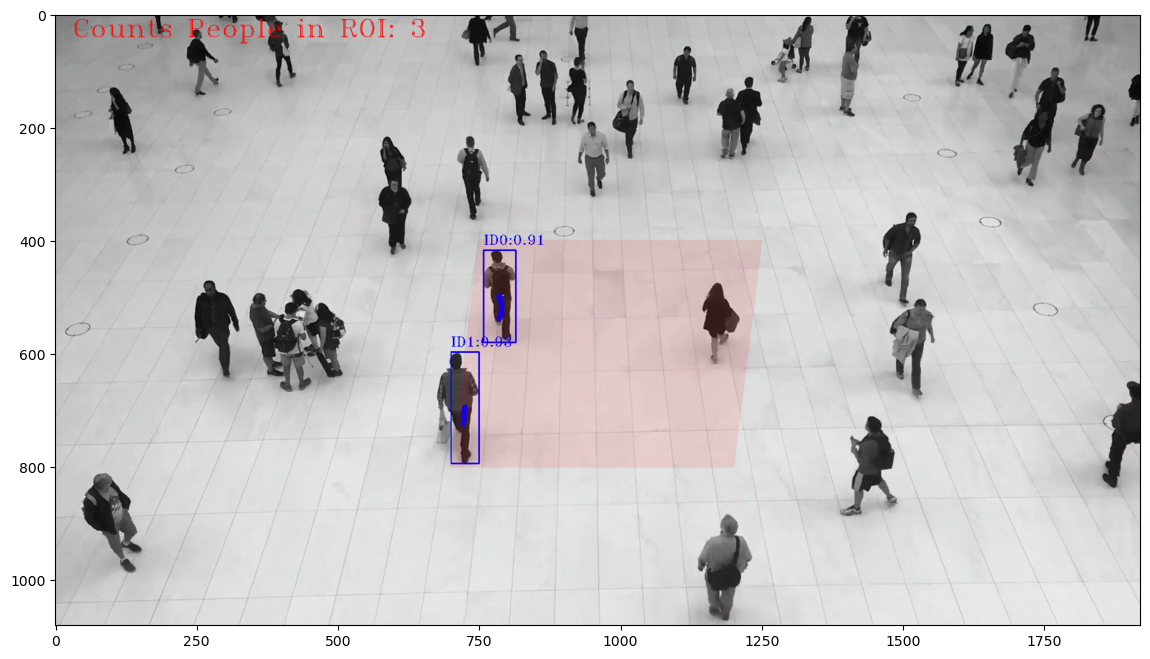

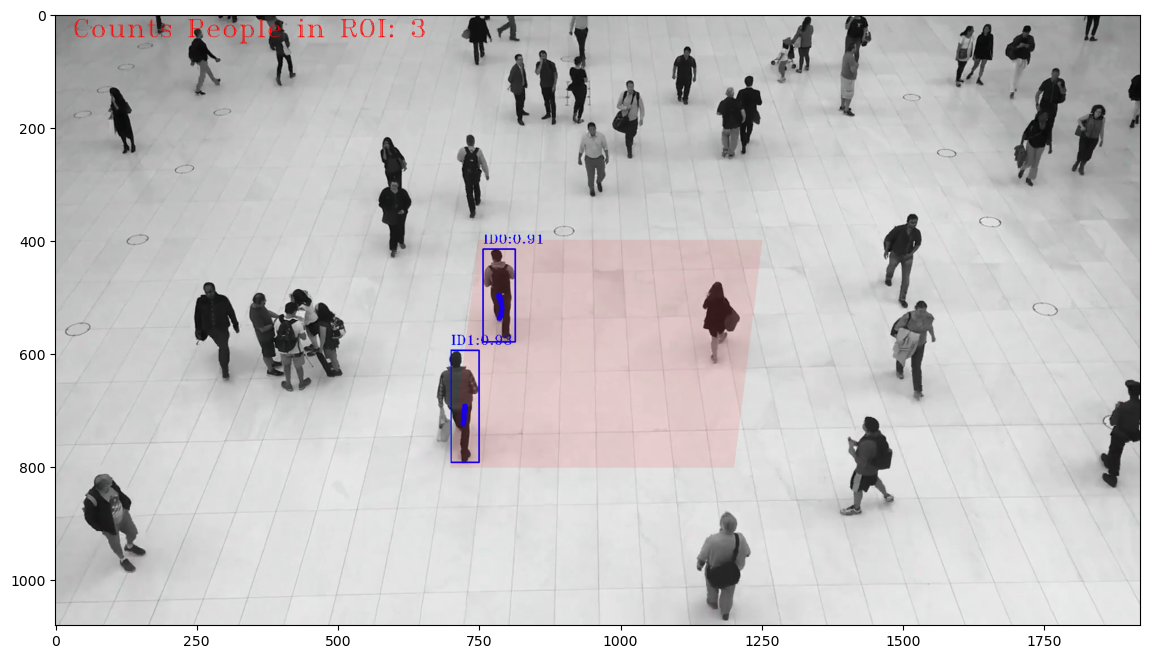

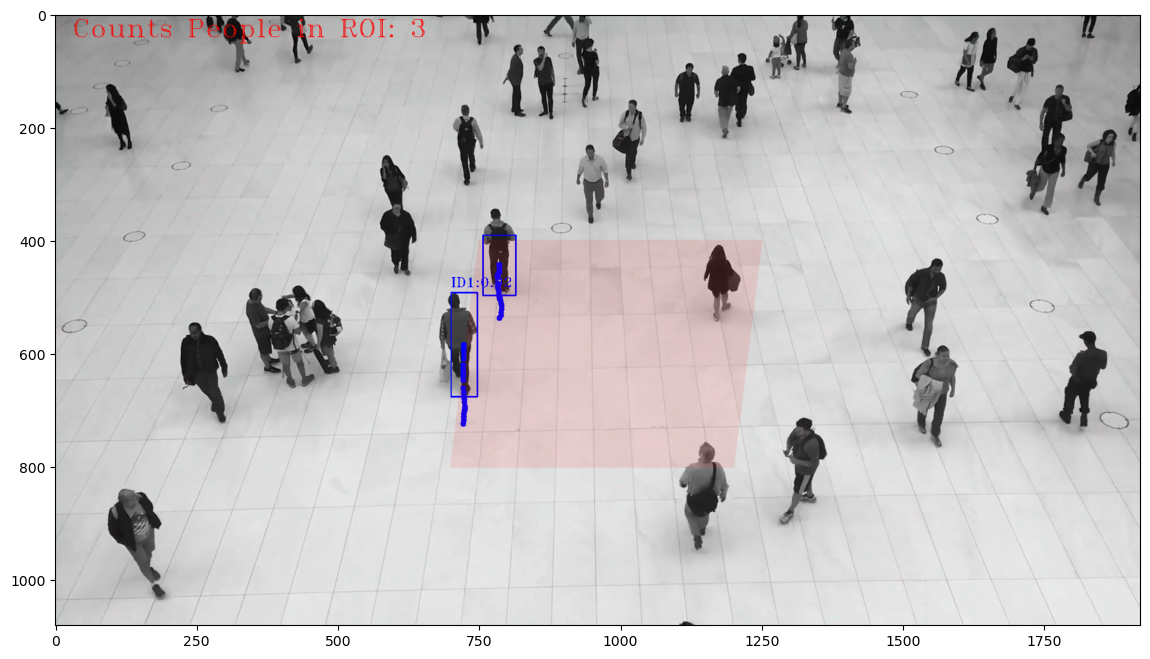

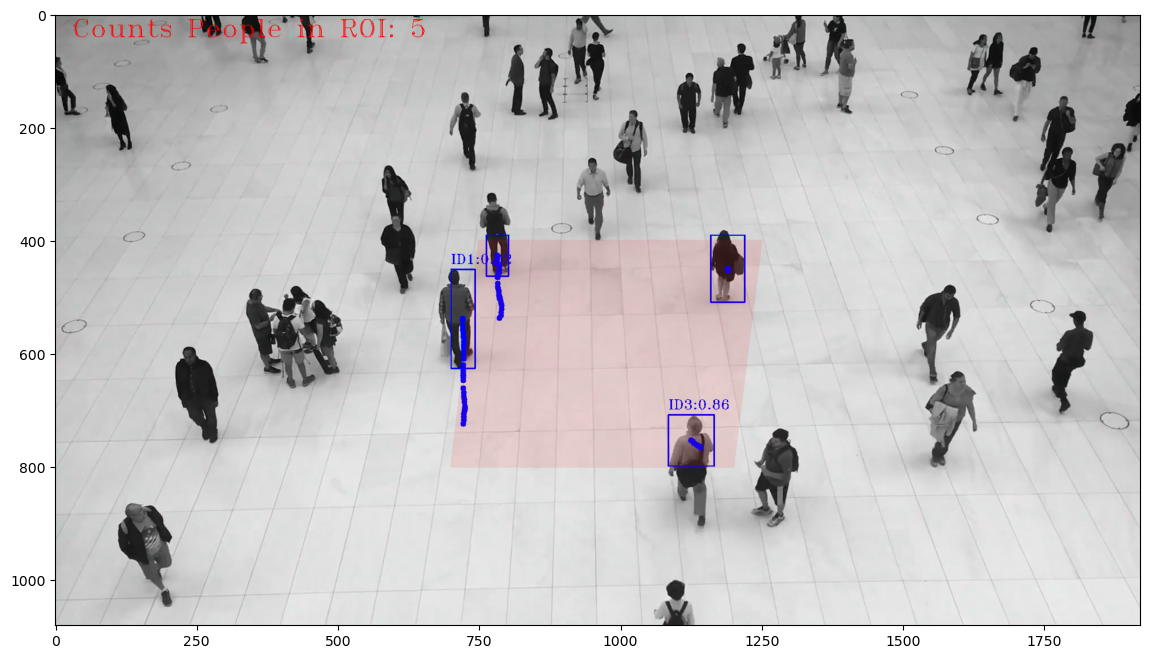

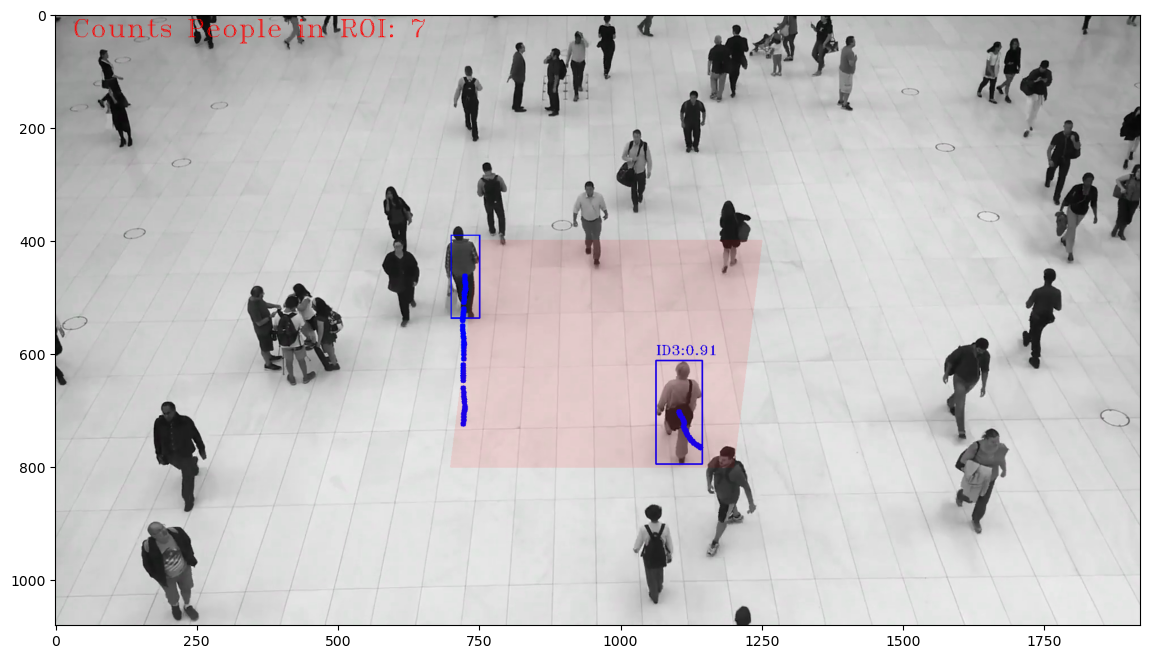

In [7]:
# Checking samples of processed frames
for i in [10, 11, 33, 44, 66]:
    plt.figure(figsize =( 14, 10))
    plt.imshow(frames_list[i])
    plt.show()

# Executing Result Video 

In [8]:
#output video result
frac = 0.7 
Video(data='det_result.mp4', embed=True, height=int(720 * frac), width=int(1280 * frac))